# Review Problems

### Topics
* Compute: Pandas Basics, `NaN`s, Grouping/Pivot, Joining, Matplotlib/Seaborn, Regex, HTML Parsing, Sklearn
* Concepts: 
    - Messy Data, Imputation, Smoothing, Geo Data, 
    - Requests, Text Data (Cleaning, BOW, TF-IDF), Features, Bias-Variance, Model Evaluation, Inference

In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

### Split-Apply-Combine

* A DataFrame `boxes` contains the dimensions (`length, width, height`) of boxes made by 10 box-making machines.
* The columns of the DataFrame are `machine_id, length, width, height`.
* For each of the following functions `f`, what is the output of running the code:
```
boxes.groupby('machine_id').apply(f)
```
Is it a Series or DataFrame? What are the indices/columns? What are the dimensions? What does the data represent statistically?

In [ ]:
f = lambda x: np.mean(x['length'] * x['width'] * x['height'])

def f(x):
    mean, median = x['length'].mean(), x['length'].median()
    return pd.Series({'mean': mean, 'median': median})

def f(x): 
    y = x.copy()
    y['c'] = np.mean(x['length'] * x['width'] * x['height'])
    return y

def f(x):
    v = x['length'] * x['width'] * x['height']
    m, s = v.mean(), v.std()
    return (v - m) / s



### Groupby solutions

1. Series with index machine id, values mean volume for machine
2. DataFrame with index machine id, and columns giving mean/median of the box length for each machine
3. DataFrame with multi-index (machine_id, df.index), columns same as df + the average volumne for the machine that made given box.
4. Series with multi-index (machine_id, df.index), giving the standardized volume (by machine_id) of each box.

In [ ]:
boxes = pd.DataFrame({
    'machine_id': np.random.randint(0, 10, size=100),
    'length': np.random.normal(10, 1, size=100),
    'width': np.random.normal(14, 1, size=100),
    'height': np.random.normal(6, 1, size=100),

})

In [ ]:
boxes.head()

In [ ]:
f = lambda x: np.mean(x['length'] * x['width'] * x['height'])

boxes.groupby('machine_id').apply(f)

In [ ]:
G = boxes.groupby('machine_id')
grp = G.get_group(4)
grp.head()


In [ ]:
f(grp)

In [ ]:
def f(x):
    mean, median = x['length'].mean(), x['length'].median()
    return pd.Series({'mean': mean, 'median': median})

boxes.groupby('machine_id').apply(f)

In [ ]:
G = boxes.groupby('machine_id')
grp = G.get_group(4)
grp.head()

In [ ]:
f(grp)

In [ ]:
def f(x): 
    y = x.copy()
    y['c'] = np.mean(x['length'] * x['width'] * x['height'])
    return y

boxes.groupby('machine_id').apply(f).head()

In [ ]:
G = boxes.groupby('machine_id')
grp = G.get_group(4)
grp.head()

In [ ]:
f(grp).head()

In [ ]:

def f(x):
    v = x['length'] * x['width'] * x['height']
    m, s = v.mean(), v.std()
    return (v - m) / s

boxes.groupby('machine_id').apply(f).head()

In [ ]:
G = boxes.groupby('machine_id')
grp = G.get_group(4)
grp

In [ ]:
f(grp)

### Pivot Tables

The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.

* Calculate the survival rate by Gender (M/F) for each passenger class
* Calculate the median age of each passenger by passenger class and whether they survived

Do it with `pivot_table`. Do it with `groupby` plus other methods.

In [ ]:
titanic = pd.read_csv('titanic.csv')
titanic.head()

### Pivot Solutions

In [ ]:
titanic.pivot_table(index='Sex', columns='Pclass', values = "Survived", aggfunc=np.mean)

In [ ]:
titanic.pivot_table(index='Pclass', columns='Survived', values='Age', aggfunc=np.median)

### Tables and Statistics

Given a table `cars` of cars and their colors, compute the conditional distribution of colors by car make.

|car_make|car_color|
|---|---|
|Toyota|Black|
|Honda|White|
|Honda|Silver|
|Audi|Red|
|Ford|White|
|GMC|White|

### Table and Statistics Solutions

In [ ]:
cars = pd.DataFrame({
    'car_make': ['Toyota', 'Honda', 'Honda', 'Audi', 'Ford', 'GMC'],
    'car_color': ['Black', 'White', 'Silver', 'Red', 'White', 'White']})
cars

In [ ]:
(
    cars
    .pivot_table(index='car_color', columns='car_make', aggfunc='size')
)

In [ ]:
(
    cars
    .pivot_table(index='car_color', columns='car_make', aggfunc='size')
    .apply(lambda x:x/x.sum())
)

In [ ]:
(
    cars
    .pivot_table(index='car_color', columns='car_make', aggfunc='size')
    .fillna(0)
    .apply(lambda x:x/x.sum())
)

### Imputation

* Suppose a DataFrame `cars` contains data on ticketed cars in San Diego. The DataFrame contains two columns: 
    - `time_of_day` (binary with values "Day" or "Night")
    - `car_type` (values SUV, Van, Truck, Sedan, Coupe)
* Assuming that `time_of_day` has no `NaN` values and `car_type` is MAR dependent on `time_of_day`, write code to impute `car_type` so the imputed column has:
    - unbiased means conditional on values of `time_of_day`, and
    - unbiased variance.

### Imputation Solution

In [ ]:
# Solution
# impute using distribution of car_type conditional on time of day

def impute_with_distr(ser):
    # not the fastest way (at all)? can you make it faster? (see lecture)
    nonnulls = ser.dropna()
    return ser.apply(lambda x:nonnulls.sample(n=1) if pd.isnull(x) else x)

    
cars.groupby('time_of_day').apply(impute_with_distr)

### Summary: Multiple Imputation

Suppose you want to calculate the correlation coefficient of `col_1` (with missing values) and `col_2` (without missing values). You want to do your analysis using multiple imputation for `col_1`.

If `col_1` is MAR dependent on `col_D`, then

* Impute `col_1` from a distribution (of `col_1` conditional on `col_D`). 
    - Do this many times creating N imputed columns.
* For each imputed column, calculate the correlation coefficient of the imputed column and `col_2`.
    - You now have `N` correlation coefficients.
* Analyze this *distribution* of correlation coefficients. 
    - The mean could be considered you "single" result.


### Bias and Variance

The plots below show the error for a regression model on a training and test set, for different values of a model parameter. For which values of the parameter is the model Under/Overfit? discuss what's occurring in each region?

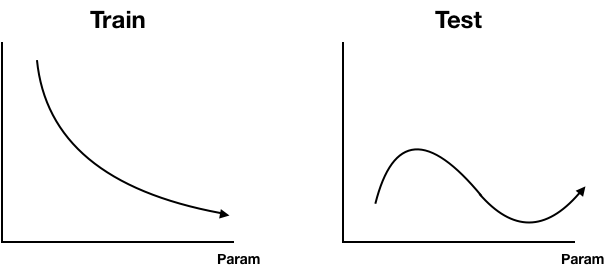

### Bias/Variance Solution

* High bias / Underfit: Train=high, Test=high
* Overfit: Train=low, Test=high

### Features

Suppose a dataset of restaurant reviews is given in a DataFrame `reviews`.

1. One-Hot Encode the 'rating' column: using `sklearn`'s `OneHotEncoder`, writing your own function, by hand.
2. Ordinal Encode the 'rating' column: using `sklearn`'s `OrdinalEncoder`, writing your own function, by hand.
3. Create two additional columns to `reviews`, each giving the 'distance between the review in a row's rating to the value `THREE`' in each feature space.

|review_id|rating|
|---|---|
|9|TWO|
|10|ONE|
|11|ONE|
|12|THREE|
|13|FIVE|
|14|FOUR|



### Features Solutions

* For code (by hand, and sklearn), see lecture!

* by hand OneHot:
```
[
    [0,1,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,1],
    [0,0,0,1,0]
]
```

* by hand Ordinal:
```
[
    [2],
    [1],
    [1],
    [3],
    [5],
    [4]
]
```

* Distance from Three OneHot:
\[$\sqrt{2}$, $\sqrt{2}$, $\sqrt{2}$, 0, $\sqrt{2}$, $\sqrt{2}$\]

* Distance from Three Ordinal:
[2,2,0,2,1]

### Text Features: Bag of Words

* Explain the idea
* What are the steps?
* What are the limitations?

### Bag of Words

1. Create a list of all words appearing among *all* text ('bag of words')
2. Create a vector, indexed by the distinct words, with counts of the words in that entry.
3. Two text entries are similar if the sum of their matches is large.
    - The sum of their matches is the same as the dot-product of the vectors!
    
First, create the bag of words by hand with the data below.

Second, for each word in the vocabulary, find the "closest documents" to that word.

In [ ]:
sentences = ["john likes to watch movies mary likes movies too",
             "john also likes to watch football games",
             "mary hates football games"]

pd.Series(sentences)

1. for each sentence, remove multiple occurrences of the word and use the word count to represent this.

```
1. {"john":1,"likes":2,"to":1,"watch":1,"movies":2,"mary":1,"too":1}
2. {"john":1,"also":1,"likes":1,"to":1,"watch":1,"football":1,"games":1}
3. {"mary":1, "hates":1, "football":1, "games":1}
```

2. Combined word frequency for our entire document. All sentences are taken into account.

```
{"likes":2, "watch":2,"football":2,"movies":2,"john":2,"to":2,"mary":2,"games":2,"too":1,"also":1,"hates":1}
```

3. Create vectors for each of the sentences

```
john likes to watch movies. mary likes movies too.
[2	1	0	2	1	1	1	0	1	0	0]
john also likes to watch football games.
[ 1	 1	1	0	1	1	0	1	0	1	0]
mary hates football games
[0	0	1	0	0	0	1	1	0	0	1]
```

### Limitations of BOW:

1. The BOW model only considers if a known word occurs in a document or not. It does not care about meaning, context, and order in which they appear.

2. For a large document, the vector size can be huge resulting in a lot of computation and time

##  Term Frequency, Inverse Document Frequency

How do we figure out which words are "important" in a document?

1. The most common words often *don't* have much meaning!
2. The very rare words are also less important!

Goal: balance these two observations.
Can you explain the idea?

## Term Frequency, Inverse Document Frequency

* The *term frequency* of a word $t$ in a document $d$, denoted ${\rm tf}(t,d)$, is the likelihood of the term appearing in the document.
* The *inverse document frequency* of a word $t$ in a set of documents $\{d_i\}$, denoted ${\rm idf}(t,d)$ is: 

$$\log(\frac{{\rm\ total\ number\ of\ documents}}{{\rm number\ of\ documents\ in\ which\ t\ appears}})$$

* The *tf-idf* of a term $t$ in document $d$ is given by the product: 

$${\rm tfidf}(t,d) = {\rm tf}(t,d) \cdot {\rm idf}(t)$$

What is the tf-idf of 'mary' in the third 'document'?

In [ ]:
sentences = ["john likes to watch movies mary likes movies too",
             "john also likes to watch football games",
             "mary hates football games"]

pd.Series(sentences)

In [ ]:
# the term frequency of 'mary' in the thid 'document'
tf = sentences.iloc[2].count('mary') / (sentences.iloc[2].count(' ') + 1)
tf

In [ ]:
idf = np.log(len(sentences) / sentences.str.contains('mary').sum())
idf

In [ ]:
tf * idf

## Regex review

Use regular expression to match:

a 10-digit phone number with dashes and parentheses:

1. a 10-digit phone number with dashes and parentheses:
`
(847)812-4567   : valid
(312)345-7512   : valid
(345)5435674    : valid
234-534-6434    : invalid 
`
2. to capture 5-digit U.S. ZIP codes that end in "22" or "30" 

3. HTML tag matching:

Useful Example: If you want to extract only a year,  parentheses `(` ,`)` will help you.
```
input = 'A 34-3456 12-05-2007, B 56-4532 11-11-2011, C 67-8945 12-01-2009'
result = re.findall(r`\d{2}-\d{2}-(\d{4})', input)  # r means "raw" string
print(result)

Output:
[`2007', `2011', `2009']
```


You need to extract information available between `<td>` and `</td>` tags, excluding the first numerical index
```
html =    <tr align="center"><td>1</td> <td>Noah</td></tr>
          <tr align="center"><td>2</td> <td>Liam</td></tr>
          <tr align="center"><td>3</td> <td>Ethan</td></tr>
          <tr align="center"><td>4</td> <td html>Michael</td></tr>
```

result:
`
['Noah', 'Liam', 'Ethan']
`

In [ ]:
import re
# Answers:

#1
match1 = re.search(r'\(\d{3}\)\d{3}\-?\d{4}', '(847)812-4567)')
#print(match1)

#2 

match2 = re.findall(r'\b[0-9]{3}(22|30)\b', "92122")
#print(match2)

#3 

html = """<tr align="center"><td>1</td> <td>Noah</td></tr>
          <tr align="center"><td>2</td> <td>Liam</td></tr>
          <tr align="center"><td>3</td> <td>Ethan</td></tr>
          <tr align="center"><td>4</td> <td html>Michael</td></tr>
       """
                    
match3 = re.findall(r'<td>\w+</td> <td>([a-zA-z]+)</td>', html)
print(match3)

Now do the opposite: try to predict the output:

Which of the following matches:

a. `(very )+(hard )?(unfair|fair) exam`

|option|answer|
|---|---|
|1)|      very hard exam|
|2)|      hard unfair exam|
|3)|      very very hard fair exam|
|4)|      very very very unfair exam|


b. `<[^>]+>`

|option|answer|
|---|---|
|1)|      `<an xml tag>`|
|2)|      `<opentag> <closetag>`|
|3)|      `</closetag>`|
|4)|      `<>`|
|5)|      `<with attribute=”77”>`|


### Answers:

a) 3, 4

b) 1, 3, 5

### Web Scraping and Beautiful Soup

It creates a parse tree for parsed pages that can be used to extract data from HTML.

html =
```
<html>
    <head>
        <title> Page title </title>
    </head>

    <body>
        <h1> This is heading 1 </h1>
        <p> This is a paragraph </p>
        <p> This is another paragraph </p>


        <h2> This is a heading 2 </h2>
        <p> This is a paragraph </p>
        <p> This is another paragraph </p>
    </body>
</html>
```

In [ ]:
html = """
<html>
	<head>
		<title> Page title </title>
	</head>

	<body>
		<h1> This is heading 1 </h1>
		<p> This is a paragraph </p>
		<p> This is another paragraph </p>
        
        
        <h2> This is a heading 2 </h2>
		<p> This is a paragraph </p>
		<p> This is another paragraph </p>
	</body>
</html>
"""

In [ ]:
# What is the output?

from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')
p = soup.find('p')
p

# How does the find work? What algorithm is used?

In [ ]:
# What is the output?

p = soup.find_all('p')
p

In [ ]:
# What is the output

[x.text for x in soup.find_all('p')]